## Excluding the First Recall
To evaluate how effectively a model accounts for the responses in our datasets, we applied a likelihood-based model comparison technique introduced by @kragel2015neural that assesses model variants based on how accurately they can predict the specific sequence in which items are recalled. According to this method, repeated items and intrusions (responses naming items not presented in the list) are included from participants' recall sequences. Given an arbitrary parameter configuration and a sequences of recalls to predict, a model simulates encoding of each item presented in the corresponding study list in its respective order. Then, beginning with the first item the participant recalled in the trial, the probability assigned by the model to the recall event is recorded. Next, the model simulates retrieval of that item, and given its updated state is used to similarly predict the next event in the recall sequence - either retrieval of another item, or termination of recall - and so on until retrieval terminates. The probability that the model assigns to each event in the recall sequence conditional on previous trial events are thus all recorded. These recorded probabilities are then log-transformed and summed to obtain the log-likelihood of the entire sequence. Across an entire dataset containing multiple trials, sequence log-likelihoods can be summed to obtain a log-likelihood of the entire dataset given the model and its parameters. Higher log-likelihoods assigned to datasets by a model correspond to better effectiveness accounting for those datasets.

To find the parameter configuration for each model that maximizes its predicted likelihood of observed data, we applied the optimization technique called differential evolution [@storn1997differential] as implemented in the Python library scipy. Differential evolution maintains a population of possible parameter configurations; at each update, the algorithm mutates each population member by stochastically mixing them with other members of the population. If the new configuration of a member is an improvement over its previous configuration, then it becomes part of the updated population. Otherwise, the new parameter configuration is discarded. Through repetition of this process, gradually driving the population toward configurations that maximize the log-likelihood of the observed data assigned by the considered model. This maximal log-likelihood and its corresponding parameter configurations form the basis of comparison between models.

When exploring how effectively the model accounts for qualitative benchmark phenomena in free recall performance such as the temporal contiguity and serial position effects, we optimized parameter configurations and evaluated performance across all subjects in the considered dataset, except where otherwise noted. For direct comparison of the log-likelihoods of recall sequences, however, we search for optimal parameters and perform comparison at the subject level, considering distributions of log-likelihood values calculated between subjects when contrasting model versions.

In [1]:
from compmemlearn.datasets import prepare_lohnas2014_data
from compmemlearn.models import Classic_CMR
from scipy.optimize import differential_evolution
from numba import njit
import numpy as np
from numba import int32
from compmemlearn.analyses import flex_mixed_spc, flex_mixed_crp, flex_mixed_pfr, fast_csp, alternative_contiguity, rpl
import matplotlib.pyplot as plt

conditions = ['Control', 'Massed', 'Spaced', 'Mixed']

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../../data/repFR.mat')

### Unique Dependencies

In [2]:
import numpy as np
from numba import njit, prange
from compmemlearn.models import Classic_CMR
from numba.typed import Dict
from numba.core import types

@njit(fastmath=True, nogil=True, parallel=True)
def lohnas_data_likelihood(trials, presentations, model_class, parameters):

    list_length = len(presentations[0])
    likelihood = np.ones((len(trials), list_length-1)) 

    for trial_index in prange(len(trials)):

        item_count = np.max(presentations[trial_index])+1
        trial = trials[trial_index]
        model = model_class(item_count, list_length, parameters)
        model.experience(model.items[presentations[trial_index]])

        model.force_recall()
        for recall_index in range(len(trial) + 1):

            # identify index of item recalled; if zero then recall is over
            if recall_index == len(trial) and len(trial) < item_count:
                recall = 0
            elif trial[recall_index] == 0:
                recall = 0
            else:
                recall = presentations[trial_index][trial[recall_index]-1] + 1

            # store probability of and simulate recalling item with this index
            if recall_index > 0:                        
                likelihood[trial_index, recall_index-1] = \
                    model.outcome_probabilities()[recall] + 10e-7

            if recall == 0:
                break
            model.force_recall(recall)

        # reset model to its pre-retrieval (but post-encoding) state
        model.force_recall(0)

    return -np.sum(np.log(likelihood))

def lohnas_objective_function(data_to_fit, presentations, model_class, fixed_parameters, free_parameters):

    """
    Generates and returns an objective function for input to support search 
    through parameter space for model fit using an optimization function.

    Returns a function that accepts a vector x specifying arbitrary values for 
    free parameters and returns evaluation of likelihood using the model 
    class, all parameters, and provided data.
    """

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value

    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return lohnas_data_likelihood(data_to_fit, presentations, model_class, parameters)

    return objective_function

In [3]:
int32=int

#@njit(nogil=True)
def simulate_array_from_presentations(
    model_class, parameters, presentations, experiment_count,  first_recall_item=np.array([])):

    # simulate retrieval for the specified number of times, tracking results in trials array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)+1), dtype=int32)
    
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            presentation = presentations[trial_index]
            item_count = np.max(presentation)+1
            
            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            
            if first_recall_item.size > 0:
                model.force_recall(first_recall_item[trial_index])
            
            recalled = model.free_recall()
            
            for i in range(len(recalled)):
                trials[experiment*len(presentations) + trial_index, i] = find_first(recalled[i], presentation) + 1
    
    return trials

#@njit(nogil=True)
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

### Conditionwise Fits
We'll fit CMR to the Lohnas Conditions One-By-One instead of altogether. Tests of generalization between study conditions will be reserved to another section.

In [4]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

cmr_results = [
    [0.75063888, 0.75094444, 0.92366083, 0.66503613, 0.90901694, 0.56730153,
     0.85689934, 1.29818073, 0.02575404, 0.08702174, 8.19615376], 
    [8.86888535e-01, 8.45701472e-01, 9.03811989e-01, 9.19054930e-01,
     4.23494614e-02, 1.00000000e+00, 1.56118802e+00, 8.17149013e+01,
     1.11164590e-02, 2.05599328e-01, 6.72137961e+00], 
    [0.82563326, 0.93089048, 0.88646915, 0.63187823, 1.,         0.31325542,
    1.26629335, 0.39640346, 0.00757724, 0.22299189, 4.84950264], 
    [0.85324254, 0.93086086, 0.9543999,  0.0847418,  0.73612449, 0.36308409,
    2.28671447, 0.37075445, 0.02250586, 0.10411078, 1.65456177]]

```python
cmr_results = []
for condition in [1, 2, 3, 4]:
    selection = list_types == condition
    cost_function = lohnas_objective_function(
        trials[selection], 
        presentations[selection],
        init_cmr,
        {'delay_drift_rate':0, 'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=True))
    print(cmr_results[-1].x)
```

In [5]:
# simulate data corresponding to each cmr_result
from numba.typed import Dict
from numba.core import types
from numpy import matlib


experiment_count = 1

sim_trials = []
sim_presentations = []
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

for i, cmr_result in enumerate(cmr_results):

    for j in range(len(cmr_result)):
        fitted_parameters[cmr_free_parameters[j]] = cmr_result[j]
        
    fitted_parameters['sampling_rule'] = 0
    fitted_parameters['mfc_familiarity_scale'] = 0
    fitted_parameters['mcf_familiarity_scale'] = 0
    fitted_parameters['drift_familiarity_scale'] = 0
    fitted_parameters['delay_drift_rate'] = 0

    sim_trials.append(simulate_array_from_presentations(
        init_cmr, fitted_parameters, presentations[list_types==i+1], experiment_count, trials[list_types==i+1][:, 0]))
    sim_presentations.append(np.matlib.repmat(presentations[list_types==i+1], experiment_count, 1))

### Serial Position Curve

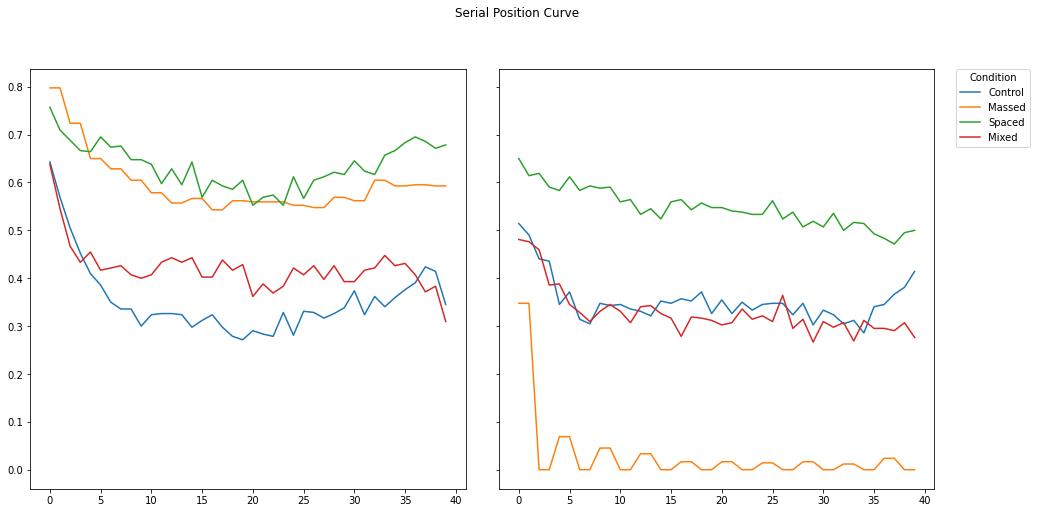

In [6]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):
    
    test_spc= flex_mixed_spc(trials[list_types==condition+1], presentations[list_types==condition+1])
    axes[0].plot(np.arange(len(test_spc)), test_spc, label=conditions[condition])

    sim_spc = flex_mixed_spc(sim_trials[condition], sim_presentations[condition])
    axes[1].plot(np.arange(len(sim_spc)), sim_spc, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='Recall Rate') 
fig.suptitle("Serial Position Curve")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Lag-CRP

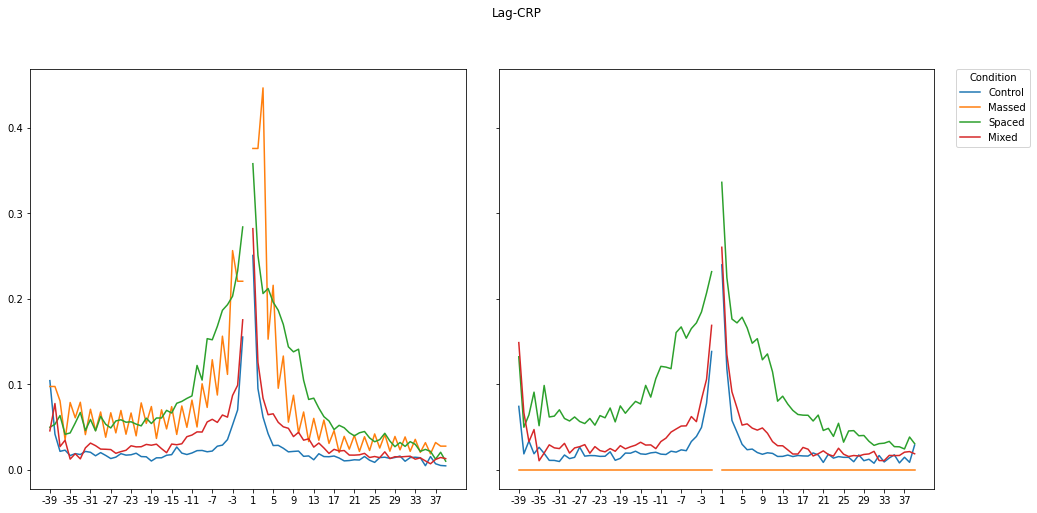

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):

    test_crp= flex_mixed_crp(trials[list_types==condition+1], presentations[list_types==condition+1])
    test_crp[len(presentations[0])-1] = np.nan
    axes[0].plot(np.arange(len(test_crp)), test_crp, label=conditions[condition])

    sim_crp = flex_mixed_crp(sim_trials[condition], sim_presentations[condition])
    sim_crp[len(presentations[0])-1] = np.nan
    axes[1].plot(np.arange(len(sim_crp)), sim_crp, label=conditions[condition])

#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability')   
axes[0].set_xticks(np.arange(0, len(test_crp), 4))
axes[0].set_xticklabels(np.arange(0, len(test_crp), 4) - 39)
axes[1].set_xticks(np.arange(0, len(sim_crp), 4))
axes[1].set_xticklabels(np.arange(0, len(sim_crp), 4) - 39)
fig.suptitle('Lag-CRP')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Probability of First Recall

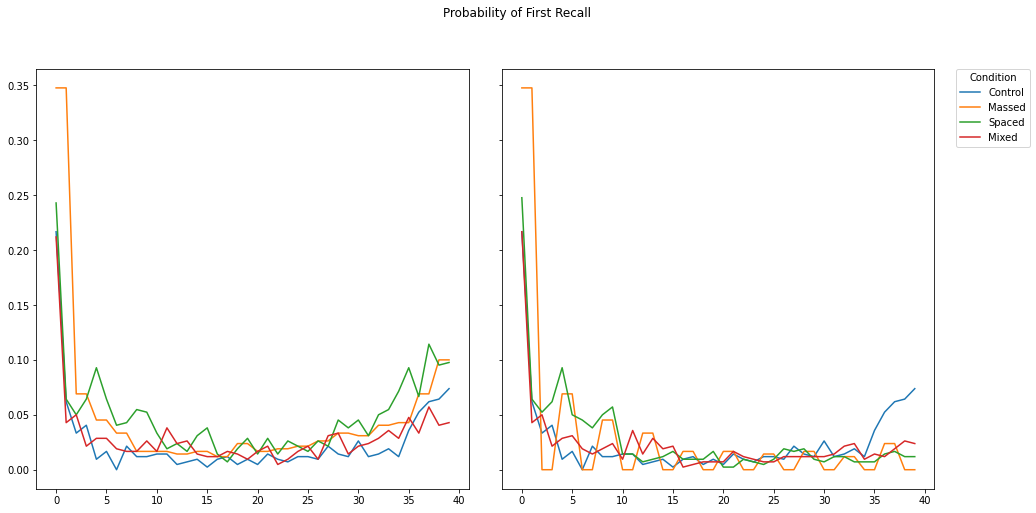

In [8]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):

    test_pfr = flex_mixed_pfr(trials[list_types==condition+1], presentations[list_types==condition+1])
    axes[0].plot(np.arange(len(test_pfr)), test_pfr, label=conditions[condition])

    sim_pfr = flex_mixed_pfr(sim_trials[condition], sim_presentations[condition])
    axes[1].plot(np.arange(len(sim_pfr)), sim_pfr, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='First Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='First Recall Rate') 
fig.suptitle("Probability of First Recall")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Conditional Stop Probability

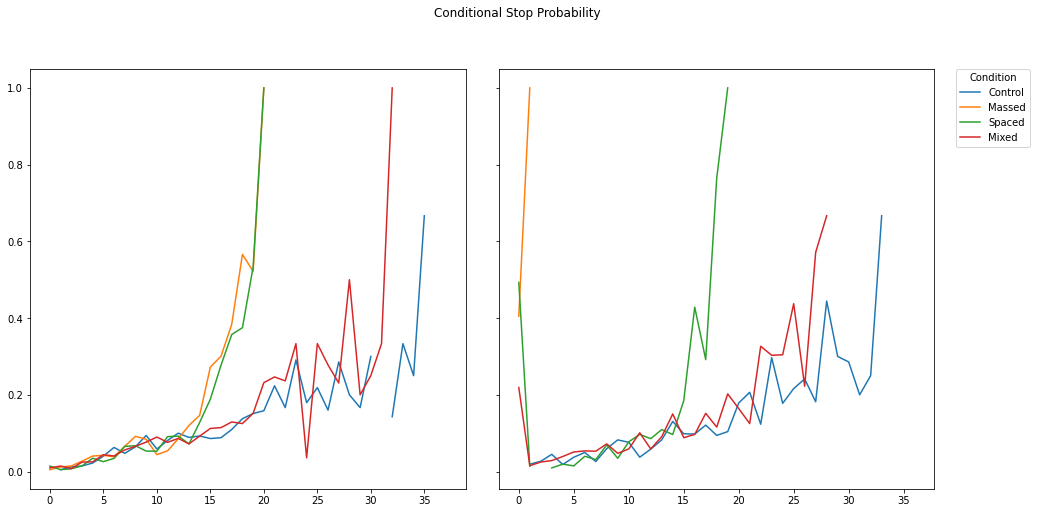

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in range(4):
    test_csp = fast_csp(trials[list_types==condition+1], list_length)
    test_csp[test_csp==0] = np.nan
    axes[0].plot(np.arange(list_length+1), test_csp, label=conditions[condition])

    sim_csp = fast_csp(sim_trials[condition], list_length)
    sim_csp[sim_csp==0] = np.nan
    axes[1].plot(np.arange(list_length+1), sim_csp, label=conditions[condition])

#plt.xlabel('Recall Position')
#plt.ylabel('Conditional Stop Probability')
fig.suptitle('Conditional Stop Probability')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

### Alternative Contiguity

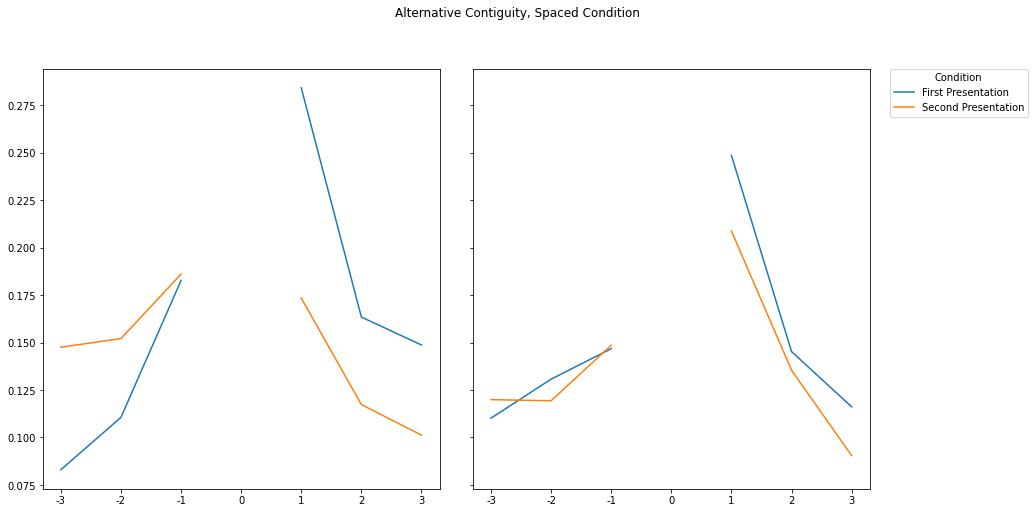

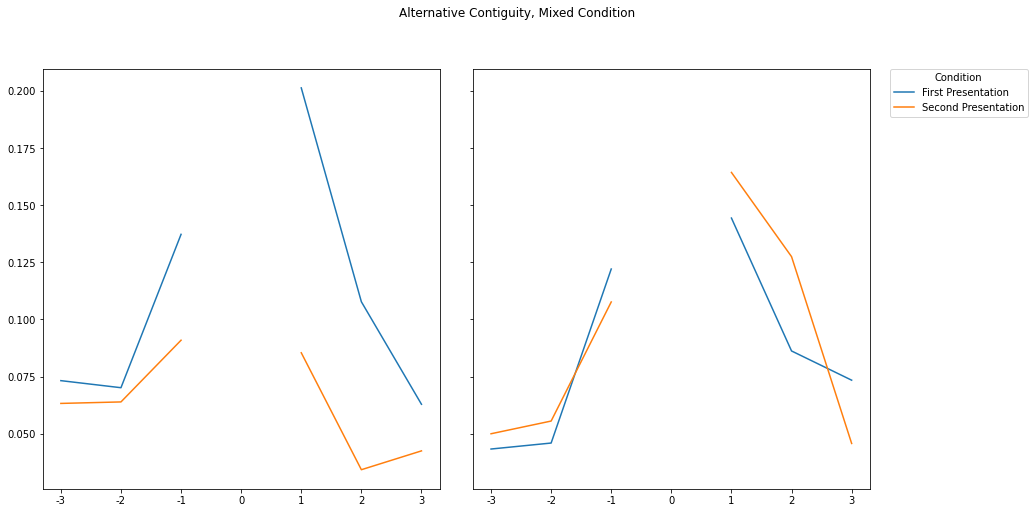

In [10]:
for condition in range(2, 4):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)
    
    test_altcrp= alternative_contiguity(
        trials[list_types==condition+1], presentations[list_types==condition+1], 6, 2)
    test_altcrp[:, list_length-1] = np.nan
    axes[0].plot(np.arange(7), test_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
    axes[0].plot(np.arange(7), test_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
    axes[0].set_xticks(np.arange(7))
    axes[0].set_xticklabels(np.arange(7) -3) 

    sim_altcrp = alternative_contiguity(
        sim_trials[condition], sim_presentations[condition], 6, 2)
    sim_altcrp[:, list_length-1] = np.nan
    axes[1].plot(np.arange(7), sim_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
    axes[1].plot(np.arange(7), sim_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
    axes[1].set_xticks(np.arange(7))
    axes[1].set_xticklabels(np.arange(7) -3)

    axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.suptitle('Alternative Contiguity, ' + conditions[condition] + ' Condition')
    plt.tight_layout(pad=3)
    #plt.xlabel('Lag')
    #plt.ylabel('Conditional Response Probability')   


### Spacing Effect

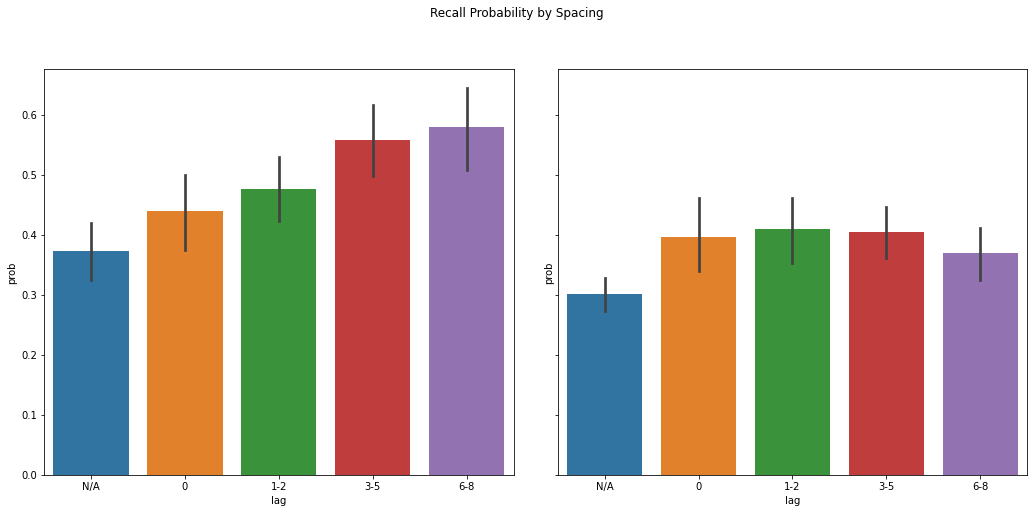

In [11]:
import seaborn as sns

condition = 4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

subject_count = len(np.unique(events.subject))
trial_count = int(np.max(events.list)/4)

data = rpl(
    presentations[list_types==condition], trials[list_types==condition], 
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[0], data=data, x='lag', y='prob')

sim_data = rpl(
    sim_presentations[3], sim_trials[3],
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[1], data=sim_data, x='lag', y='prob')
    
fig.suptitle("Recall Probability by Spacing")
plt.tight_layout(pad=3)